# Predict neighbours

Characterise local correlations by predicting time series based on their neighbours.

In [65]:
import h5py
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import matplotlib.cm

## Load data

In [3]:
history_file = h5py.File('interpolated_waterbodies_by_division_and_basin.h5', 'r')

In [25]:
waterbodies = gpd.read_file('waterbodies_joined_drainage_basins.shp')

We'll just focus on one location for now. Let's use the Mitchell River as it's broadly unregulated and monsoonal.

In [10]:
data = history_file['Carpentaria Coast']['MITCHELL RIVER (WA)']['pc_wet'][()]

In [29]:
uids = [int(a) for a in history_file['Carpentaria Coast']['MITCHELL RIVER (WA)']['uid']]

In [15]:
dates = pd.to_datetime([a.decode('ascii') for a in history_file['dates']])

## Neighbours

Use a KDTree to find the 3 nearest neighbours for each waterbody.

In [30]:
points = np.stack([
    waterbodies.loc[uids].centroid.x,
    waterbodies.loc[uids].centroid.y,
]).T

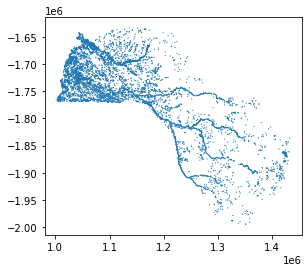

In [36]:
waterbodies.loc[uids].buffer(1000).plot()

In [33]:
kdtree = scipy.spatial.KDTree(points)

In [38]:
distances, neighbours = kdtree.query(points, k=4)

In [41]:
distances = distances[:, 1:]

In [43]:
neighbours = neighbours[:, 1:]

For each of these, we will fit a linear predictor. For a waterbody $w_i(t)$ with neighbours $w_{j,k,l}(t)$, we want to learn a map

$$
    f(w_j(t), w_k(t), w_l(t)) = w_i(t).
$$

We will reserve the last year or so of data for testing.

In [70]:
scores = []
coefs = []
for i, uid in enumerate(tqdm(uids)):
    features = np.stack([data[n] for n in neighbours[i]]).T
    X_train = features[:-365]
    X_test = features[-365:]
    y_train = data[i, :-365]
    y_test = data[i, -365:]
    lr = LinearRegression().fit(X_train, y_train)
    prd = lr.predict(X_test)
    scores.append(np.mean((prd - y_test) ** 2))
    coefs.append(lr.coef_.ravel())

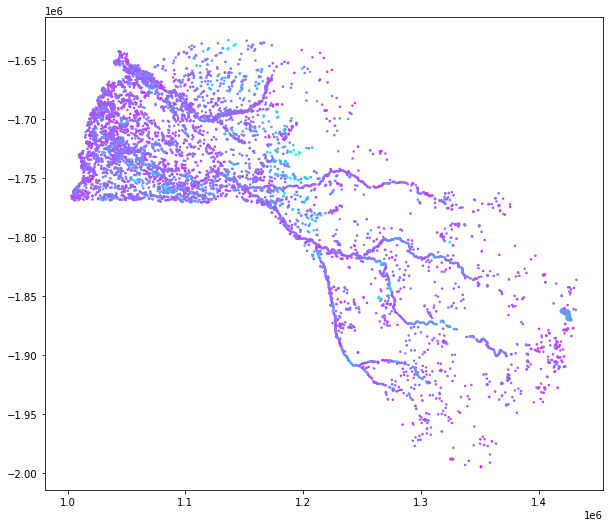

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
waterbodies.loc[uids].buffer(1000).plot(color=matplotlib.cm.cool(np.log10(scores) / np.log10(scores).max()), ax=ax)

We could also look at the coefficients for each waterbody.

In [71]:
coefs = np.array(coefs)

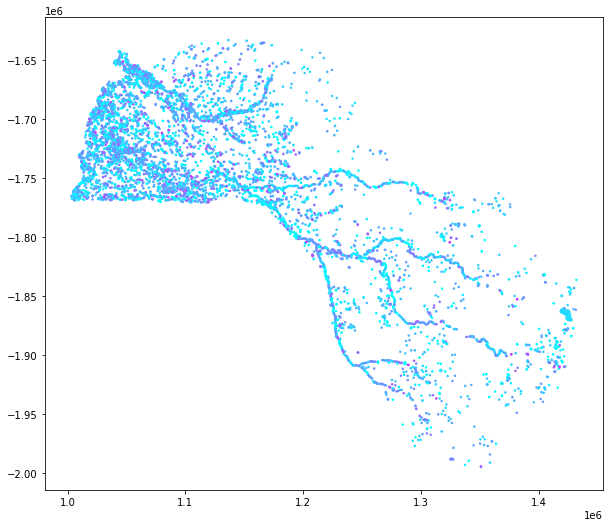

In [75]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
waterbodies.loc[uids].buffer(1000).plot(color=matplotlib.cm.cool(coefs[:, 0] / coefs[:, 0].max()), ax=ax)

In [78]:
c = abs(coefs / coefs.max(axis=0, keepdims=True))

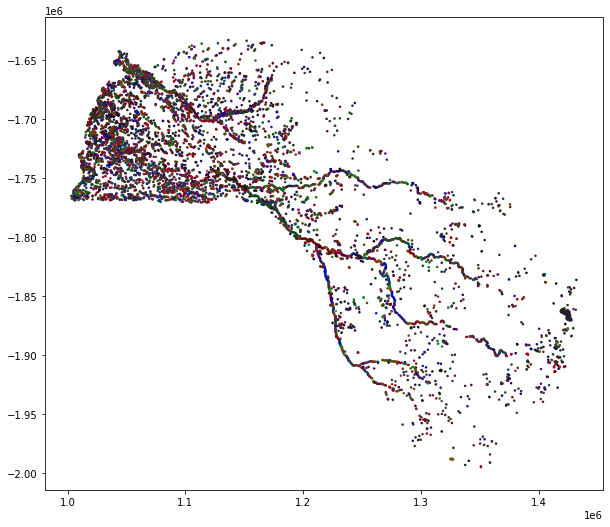

In [79]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
waterbodies.loc[uids].buffer(1000).plot(color=c, ax=ax)

This isn't looking too useful.